In [5]:
import pandas as pd
from analysis_functions import get_power_data, compute_baseline_stats, detect_power_surges, compute_surge_vs_simpipe_start_endtime_diffs
from analysis_functions import plot_enhanced_visualization

In [6]:
# Data to compare
#data_path = "./data_carbontracker/conf-1/power-run3.xls"                                                                # Tapo Smart plug data measurement
#corresponding_dataset_path = "./data_carbontracker/conf-1/run3.dat"                                                     # Carbontracker/SIMPIPE data

confNr = 5
runNr = 4
simpipe_datetime_shift = 0
#simpipe_datetime_shift = 90.6   # minutes to shift data (conf-1)
#simpipe_datetime_shift = 90.3   # minutes to shift data (conf-2)
#simpipe_datetime_shift = 112   # minutes to shift data (conf-3)
#simpipe_datetime_shift = 121.0   # minutes to shift data (conf-4)
simpipe_datetime_shift = 122.0   # minutes to shift data (conf-5)
#simpipe_datetime_shift = 124.7   # minutes to shift data (conf-6)

data_path = f"./data_carbontracker/conf-{confNr}/power-run{runNr}.xls"                                                                # Tapo Smart plug data measurement
corresponding_dataset_path = f"./data_carbontracker/conf-{confNr}/run{runNr}.dat"                                                     # Carbontracker/SIMPIPE data

In [7]:
power_data = get_power_data(data_path)                                                                                  # Tapo Smart plug data
carbontracker_simpipe_data = pd.read_csv(corresponding_dataset_path, delim_whitespace=True, comment='#', header=0)      # Carbontracker/SIMPIPE data

if simpipe_datetime_shift != 0:
    carbontracker_simpipe_data = carbontracker_simpipe_data.copy()
    # Convert start and stop columns to datetime if they aren't already
    carbontracker_simpipe_data["start"] = pd.to_datetime(carbontracker_simpipe_data["start"])
    carbontracker_simpipe_data["stop"] = pd.to_datetime(carbontracker_simpipe_data["stop"])
    # Now apply the time shift
    carbontracker_simpipe_data["start"] += pd.Timedelta(minutes=simpipe_datetime_shift)
    carbontracker_simpipe_data["stop"] += pd.Timedelta(minutes=simpipe_datetime_shift)

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_82446/3134801699.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  carbontracker_simpipe_data = pd.read_csv(corresponding_dataset_path, delim_whitespace=True, comment='#', header=0)      # Carbontracker/SIMPIPE data


In [8]:
# runNr 1
#min_duration_minutes = 15           # minimum duration (s) for a surge to be considered
#surge_threshold_multiplier = 1.02   # threshold multiplier for surge detection (relative to baseline)

# runNr 2
#min_duration_minutes = 15           # minimum duration (s) for a surge to be considered
#surge_threshold_multiplier = 1.03   # threshold multiplier for surge detection (relative to baseline)

# runNr 3
min_duration_minutes = 60           # minimum duration (s) for a surge to be considered
surge_threshold_multiplier = 1.01   # threshold multiplier for surge detection (relative to baseline)

baseline_stats = compute_baseline_stats(df=power_data, percentile_threshold=70, print_stats=True)
surge_periods, surge_threshold = detect_power_surges(power_data, baseline_stats, min_duration_minutes=min_duration_minutes, surge_threshold_multiplier=surge_threshold_multiplier)

     compute_baseline_stats -- Baseline analysis...
      Power threshold for baseline: 209.9 W
      Baseline periods: 201 out of 288 (69.8%)
      Mean baseline power: 203.4 W
      Median baseline power: 203.0 W
      Std baseline power: 2.6 W
      Power range: 199.0 - 209.0 W
      Mean baseline energy per period: 0.016952 kWh
      Total baseline energy: 3.4073 kWh



Carbontracker period: 2025-09-15 09:17:49 to 2025-09-15 13:47:42
Power data period: 2025-09-14 15:10:00 to 2025-09-15 15:05:00


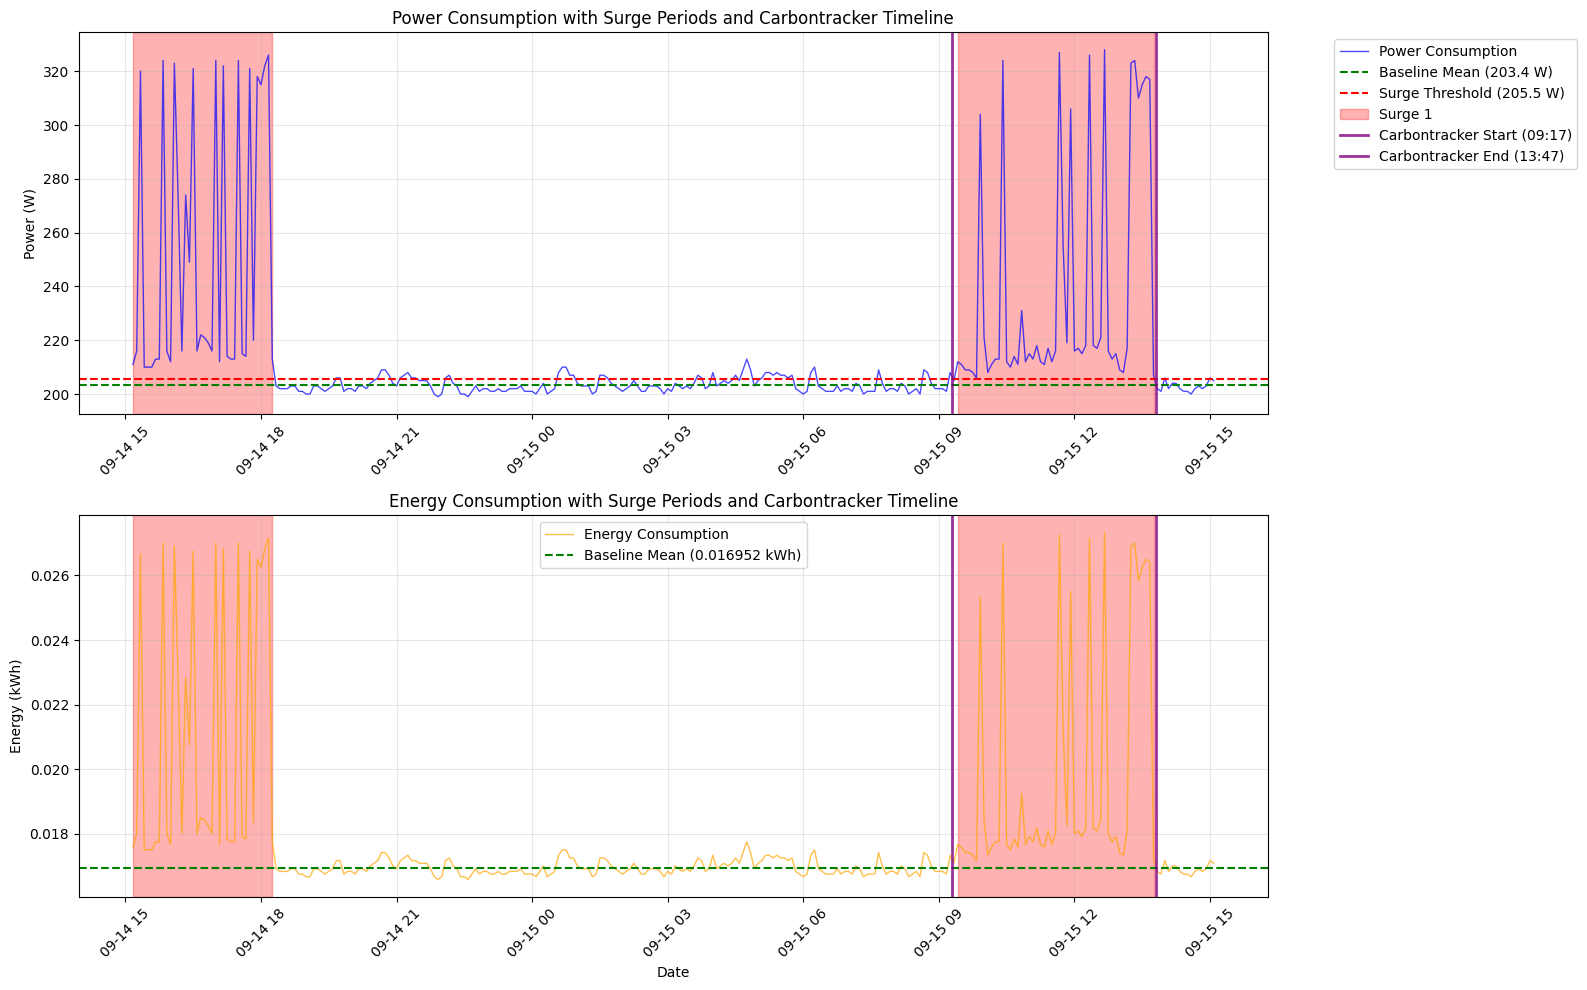

=== CARBONTRACKER vs POWER SURGE ANALYSIS ===
Carbontracker monitoring period: 09:17 - 13:47
Carbontracker duration: 4.50 hours

Overlap analysis with detected surge periods:
  Surge 1: No overlap
    Surge: 15:10 - 18:15
  Surge 2: 100.0% overlap (260.0/260.0 minutes)
    Surge: 09:25 - 13:45
    Overlap: 09:25 - 13:45

Power statistics during Carbontracker period:
  Average power: 237.6 W
  Peak power: 328.0 W
  Total energy: 1.0694 kWh
  Carbontracker reported energy: 0.2851 kWh
  Energy difference: 0.7843 kWh


In [9]:
plot_enhanced_visualization(carbontracker_simpipe_data, power_data, baseline_stats, surge_periods, surge_threshold)

In [10]:
compute_surge_vs_simpipe_start_endtime_diffs(carbontracker_simpipe_data=carbontracker_simpipe_data, surge_periods=surge_periods)

=== TIME DIFFERENCE ANALYSIS ===
Carbontracker start time: 2025-09-15 09:17:49
Carbontracker stop time: 2025-09-15 13:47:42
Carbontracker duration: 269.9 minutes

Surge 1:
  Surge start: 2025-09-14 15:10:00
  Surge end: 2025-09-14 18:15:00
  Start time difference from carbontracker start:
    -18.13 hours (1087.8 minutes) BEFORE carbontracker start
  End time difference from carbontracker stop:
    -19.55 hours (1172.7 minutes) BEFORE carbontracker stop

Surge 2:
  Surge start: 2025-09-15 09:25:00
  Surge end: 2025-09-15 13:45:00
  Start time difference from carbontracker start:
    +0.12 hours (7.2 minutes) AFTER carbontracker start
  End time difference from carbontracker stop:
    -0.04 hours (2.7 minutes) BEFORE carbontracker stop

=== TIMING RELATIONSHIPS SUMMARY ===
Surges starting before carbontracker         : 1
Surges overlapping with carbontracker period : 1
Surges starting after carbontracker          : 0

Closest surge to carbontracker start      : Surge 2
Time difference: 

# Analysis of time diffs
We see a clear difference between the SIMPIPE/Carbontracker pipeline start and stop timestamps and the power surges.

What could be the culpit of this discrepancy I do not know. But there is a big discrepancy in the timestamps.

We therefore compute the differences
* Dstart = diff(simpipe_start - estimated_power_surge_start)
* Dend = diff(simpipe_end - estimated_power_surge_end)
* Delta = (simpipe_start - simpipe_end) - Dend
* Kappa = (simpipe_start - simpipe_end) - Delta

In [43]:
# Data for surge time differences.
# data contains table of surge time differences between Tapo Smart plug and Carbontracker/SIMPIPE for all runs.
# Columns: Configuration, RunNr, Start_Time_Diff_minutes, End_Time_Diff_meconds, SIMPIPE_Duration_minutes
surge_time_diffs = pd.read_csv("./data_carbontracker/surge_time_diffs.dat", delim_whitespace=True, comment='#', header=0)
# isna
nan_values = surge_time_diffs[surge_time_diffs.isna()["duration"]]
# remove NaN values
surge_time_diffs = surge_time_diffs.dropna()
# compute delta = End_Time_Diff_meconds - Start_Time_Diff_minutes
surge_time_diffs['Delta'] = surge_time_diffs['duration'] - surge_time_diffs['endDiff']
# compute tapo_power_duration
surge_time_diffs['tapo_power_duration'] = surge_time_diffs['startDiff'] - surge_time_diffs['endDiff'] + surge_time_diffs['duration']
# duration diff (diff between estimated power surge in Tapo data and SIMPIPE data)
surge_time_diffs['tapo_simpipe_duration_diff'] = surge_time_diffs['duration'] - surge_time_diffs['tapo_power_duration']

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_46876/2277159778.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  surge_time_diffs = pd.read_csv("./data_carbontracker/surge_time_diffs.dat", delim_whitespace=True, comment='#', header=0)


In [8]:
surge_time_diffs

,configuration,runNr,startDiff,endDiff,duration,Delta,tapo_power_duration,tapo_simpipe_duration_diff
0,conf-1,1,138.9,118.9,205.1,86.2,225.1,-20.0
1,conf-1,2,152.2,118.3,208.9,90.6,242.8,-33.9
2,conf-1,3,123.0,118.6,204.4,85.8,208.8,-4.4
3,conf-1,4,141.9,117.6,204.3,86.7,228.6,-24.3
4,conf-2,1,135.4,115.3,200.1,84.8,220.2,-20.1
5,conf-2,2,126.7,86.6,200.2,113.6,240.3,-40.1
6,conf-2,3,150.1,109.9,200.2,90.3,240.4,-40.2
7,conf-2,4,122.2,113.5,203.7,90.2,212.4,-8.7
8,conf-3,1,152.2,119.2,198.0,78.8,231.0,-33.0
9,conf-3,2,150.7,88.0,197.7,109.7,260.4,-62.7


In [9]:
surge_time_diffs.startDiff.mean()
#surge_time_diffs.endDiff.mean()

np.float64(133.51)

In [10]:
# these configurations needs to be rerun:
nan_values

,configuration,runNr,startDiff,endDiff,duration
16,conf-5,1,NaN,NaN,NaN
17,conf-5,2,NaN,NaN,NaN
18,conf-5,3,NaN,NaN,NaN
19,conf-5,4,NaN,NaN,NaN


In [11]:
baseline_stats

{'threshold_power': np.float64(211.0),
 'baseline_periods': 210,
 'total_periods': 288,
 'baseline_percentage': 72.91666666666666,
 'mean_power': np.float64(204.78095238095239),
 'median_power': np.float64(204.0),
 'std_power': np.float64(3.026141138332635),
 'min_power': np.int64(199),
 'max_power': np.int64(211),
 'mean_energy': np.float64(0.017065079365079366),
 'total_baseline_energy': np.float64(3.583666666666667)}

In [12]:
power_data

,Date,Power(W),Energy(kWh)
1,2025-09-03 15:25:00,201,0.016750
2,2025-09-03 15:30:00,209,0.017417
3,2025-09-03 15:35:00,213,0.017750
4,2025-09-03 15:40:00,217,0.018083
5,2025-09-03 15:45:00,217,0.018083
...,...,...,...
284,2025-09-04 15:00:00,318,0.026500
285,2025-09-04 15:05:00,324,0.027000
286,2025-09-04 15:10:00,212,0.017667
287,2025-09-04 15:15:00,206,0.017167
